 optuna , concordance index , kalpan meier

In [ ]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 9.4 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=11497cf134ba132208d1127f724bf03d724bb479bcc48c159311e8c2d8ac0f55
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [ ]:
!pip install optuna-integration[lightgbm]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 3.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [ ]:
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, brier_score_loss, mean_squared_error, classification_report
from lightgbm import LGBMClassifier, LGBMRegressor
import lightgbm as lgb
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter
from sklearn.inspection import PartialDependenceDisplay
from sklearn.calibration import calibration_curve
import matplotlib.cm as cm
from sklearn.calibration import CalibratedClassifierCV

In [ ]:
import optuna
from optuna.integration import LightGBMPruningCallback

In [ ]:
meta_data = "/content/drive/MyDrive/equity-post-HCT-survival-predictions/data_dictionary.csv"

In [ ]:
df_md = pd.read_csv(meta_data)

In [ ]:
df_md.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   variable     59 non-null     object
 1   description  58 non-null     object
 2   type         59 non-null     object
 3   values       36 non-null     object
dtypes: object(4)
memory usage: 2.0+ KB


In [ ]:
print(df_md)

                  variable                                        description  \
0                dri_score                         Refined disease risk index   
1            psych_disturb                            Psychiatric disturbance   
2               cyto_score                                  Cytogenetic score   
3                 diabetes                                           Diabetes   
4         hla_match_c_high  Recipient / 1st donor allele level (high resol...   
5           hla_high_res_8  Recipient / 1st donor allele-level (high resol...   
6               tbi_status                                                TBI   
7               arrhythmia                                         Arrhythmia   
8            hla_low_res_6  Recipient / 1st donor antigen-level (low resol...   
9               graft_type                                         Graft type   
10               vent_hist                  History of mechanical ventilation   
11             renal_issue  

In [ ]:
train_dataset = "/content/drive/MyDrive/equity-post-HCT-survival-predictions/train.csv"

In [ ]:
df_train = pd.read_csv(train_dataset)

In [ ]:
df_train.columns

Index(['ID', 'dri_score', 'psych_disturb', 'cyto_score', 'diabetes',
       'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia',
       'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue',
       'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status',
       'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6',
       'hla_match_c_low', 'rituximab', 'hla_match_drb1_low',
       'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail',
       'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct',
       'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe',
       'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer',
       'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue',
       'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score',
       'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related',
       'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_hi

In [ ]:
df_train.describe()

ID  hla_match_c_high  hla_high_res_8  hla_low_res_6  \
count  28800.000000      24180.000000    22971.000000   25530.000000   
mean   14399.500000          1.764516        6.876801       5.143322   
std     8313.988213          0.431941        1.564313       1.207757   
min        0.000000          0.000000        2.000000       2.000000   
25%     7199.750000          2.000000        6.000000       4.000000   
50%    14399.500000          2.000000        8.000000       6.000000   
75%    21599.250000          2.000000        8.000000       6.000000   
max    28799.000000          2.000000        8.000000       6.000000   

       hla_high_res_6  hla_high_res_10  hla_match_dqb1_high    hla_nmdp_6  \
count    23516.000000     21637.000000         23601.000000  24603.000000   
mean         5.109202         8.617230             1.736876      5.160346   
std          1.214162         1.905125             0.447687      1.203240   
min          0.000000         3.000000             0.000000      2.000000   
25%          4.000000         7.000000             1.000000      4.000000   
50%          6.000000        10.000000             2.000000      6.000000   
75%          6.000000        10.000000             2.000000      6.000000   
max          6.000000        10.000000             2.000000      6.000000   

       hla_match_c_low  hla_match_drb1_low  ...    age_at_hct  \
count     26000.000000        26157.000000  ...  28800.000000   
mean          1.757808            1.715296  ...     38.663162   
std           0.435453            0.451282  ...     21.147581   
min           0.000000            1.000000  ...      0.044000   
25%           2.000000            1.000000  ...     19.539000   
50%           2.000000            2.000000  ...     41.006000   
75%           2.000000            2.000000  ...     55.965250   
max           2.000000            2.000000  ...     73.726000   

       hla_match_a_low  hla_match_b_high  comorbidity_score  karnofsky_score  \
count     26410.000000       24712.00000       28323.000000      27930.00000   
mean          1.709087           1.69962           1.702327         83.83208   
std           0.458259           0.46518           1.994443         11.02884   
min           0.000000           0.00000           0.000000         40.00000   
25%           1.000000           1.00000           0.000000         70.00000   
50%           2.000000           2.00000           1.000000         90.00000   
75%           2.000000           2.00000           2.000000         90.00000   
max           2.000000           2.00000          10.000000        100.00000   

       hla_low_res_8  hla_match_drb1_high  hla_low_res_10           efs  \
count   25147.000000         25448.000000    23736.000000  28800.000000   
mean        6.903448             1.707128        8.664687      0.539306   
std         1.565017             0.461179        1.882746      0.498461   
min         2.000000             0.000000        4.000000      0.000000   
25%         6.000000             1.000000        7.000000      0.000000   
50%         8.000000             2.000000       10.000000      1.000000   
75%         8.000000             2.000000       10.000000      1.000000   
max         8.000000             2.000000       10.000000      1.000000   

           efs_time  
count  28800.000000  
mean      23.237678  
std       24.799748  
min        0.333000  
25%        5.619750  
50%        9.796500  
75%       35.100000  
max      156.819000  

[8 rows x 25 columns]

In [ ]:
df_train = df_train.drop(columns=["ID"])

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 59 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   dri_score               28646 non-null  object 
 1   psych_disturb           26738 non-null  object 
 2   cyto_score              20732 non-null  object 
 3   diabetes                26681 non-null  object 
 4   hla_match_c_high        24180 non-null  float64
 5   hla_high_res_8          22971 non-null  float64
 6   tbi_status              28800 non-null  object 
 7   arrhythmia              26598 non-null  object 
 8   hla_low_res_6           25530 non-null  float64
 9   graft_type              28800 non-null  object 
 10  vent_hist               28541 non-null  object 
 11  renal_issue             26885 non-null  object 
 12  pulm_severe             26665 non-null  object 
 13  prim_disease_hct        28800 non-null  object 
 14  hla_high_res_6          23516 non-null

In [ ]:
df_train_numeric = df_train.select_dtypes(include=['int64', 'float64'])

In [ ]:
corr_matrix = df_train_numeric.corr()

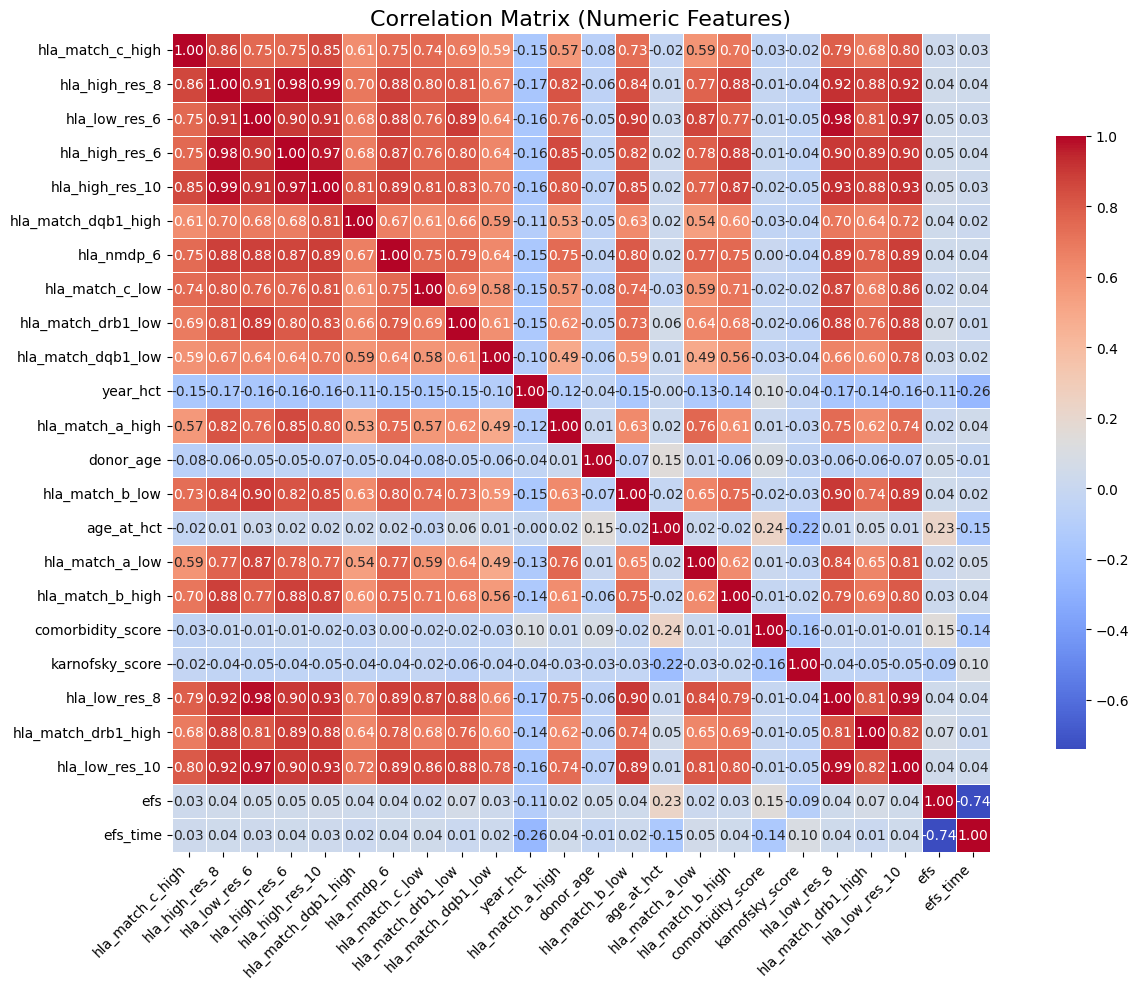

In [ ]:
plt.figure(figsize=(14, 10))

sns.heatmap(corr_matrix,
            cmap='coolwarm',
            annot=True,
            fmt=".2f",
            linewidths=0.5,
            square=True,
            cbar_kws={"shrink": 0.75})

plt.title('Correlation Matrix (Numeric Features)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

1. efs & efs_time = -0.74
2. hla_low_res ->10,8,6 (above 0.9)
3. hla_high_res ->10,8,6 (above 0.9)
4. strong correlation exists between all hla_match_* variables across high and low resolution (r > 0.75)
5. efs -> age_at_hct (0.23) & comoribidity_score(0.15) &  efs -> year_hct(-0.11) & karnofsky_score(-0.09)
6. efs_time -> karnofsky_score (0.10) & efs_time -> year(-0.26) &age_at_hct(-0.15) & comoribidity_score (-0.14)
7. most of features wrt efs and efs_time are low

In [ ]:
df_train.isnull().sum()

dri_score                   154
psych_disturb              2062
cyto_score                 8068
diabetes                   2119
hla_match_c_high           4620
hla_high_res_8             5829
tbi_status                    0
arrhythmia                 2202
hla_low_res_6              3270
graft_type                    0
vent_hist                   259
renal_issue                1915
pulm_severe                2135
prim_disease_hct              0
hla_high_res_6             5284
cmv_status                  634
hla_high_res_10            7163
hla_match_dqb1_high        5199
tce_imm_match             11133
hla_nmdp_6                 4197
hla_match_c_low            2800
rituximab                  2148
hla_match_drb1_low         2643
hla_match_dqb1_low         4194
prod_type                     0
cyto_score_detail         11923
conditioning_intensity     4789
ethnicity                   587
year_hct                      0
obesity                    1760
mrd_hct                   16597
in_vivo_tcd                 225
tce_match                 18996
hla_match_a_high           4301
hepatic_severe             1871
donor_age                  1808
prior_tumor                1678
hla_match_b_low            2565
peptic_ulcer               2419
age_at_hct                    0
hla_match_a_low            2390
gvhd_proph                  225
rheum_issue                2183
sex_match                   261
hla_match_b_high           4088
race_group                    0
comorbidity_score           477
karnofsky_score             870
hepatic_mild               1917
tce_div_match             11396
donor_related               158
melphalan_dose             1405
hla_low_res_8              3653
cardiac                    2542
hla_match_drb1_high        3352
pulm_moderate              2047
hla_low_res_10             5064
efs                           0
efs_time                      0
dtype: int64

1. Multiple HLA and clinical features have moderate missingness (10–30%) and may require imputation for models sensitive to missing values (e.g., donor_age, karnofsky_score)
2. Features with very high missingness (>50%) such as tce_match, tce_imm_match, mrd_hct are candidates for exclusion


In [ ]:
skewness = df_train_numeric.skew().sort_values(ascending=False)

In [ ]:
print(skewness)

efs_time               1.700399
comorbidity_score      1.474657
donor_age              0.296205
efs                   -0.157718
age_at_hct            -0.403813
karnofsky_score       -0.683249
hla_high_res_6        -0.892156
hla_low_res_6         -0.949163
hla_match_drb1_low    -0.954226
hla_match_b_high      -0.963549
hla_match_a_high      -0.970418
hla_high_res_8        -0.972463
hla_match_a_low       -0.978507
hla_match_drb1_high   -0.995453
hla_high_res_10       -0.998479
hla_nmdp_6            -1.014100
hla_low_res_8         -1.016377
hla_low_res_10        -1.042781
hla_match_b_low       -1.057330
year_hct              -1.093487
hla_match_dqb1_high   -1.184635
hla_match_c_low       -1.313565
hla_match_c_high      -1.367969
hla_match_dqb1_low    -1.450511
dtype: float64


In [ ]:
top_skewed = skewness.index.tolist()
num_features = len(top_skewed)

In [ ]:
cols = 4
rows = math.ceil(num_features / cols)

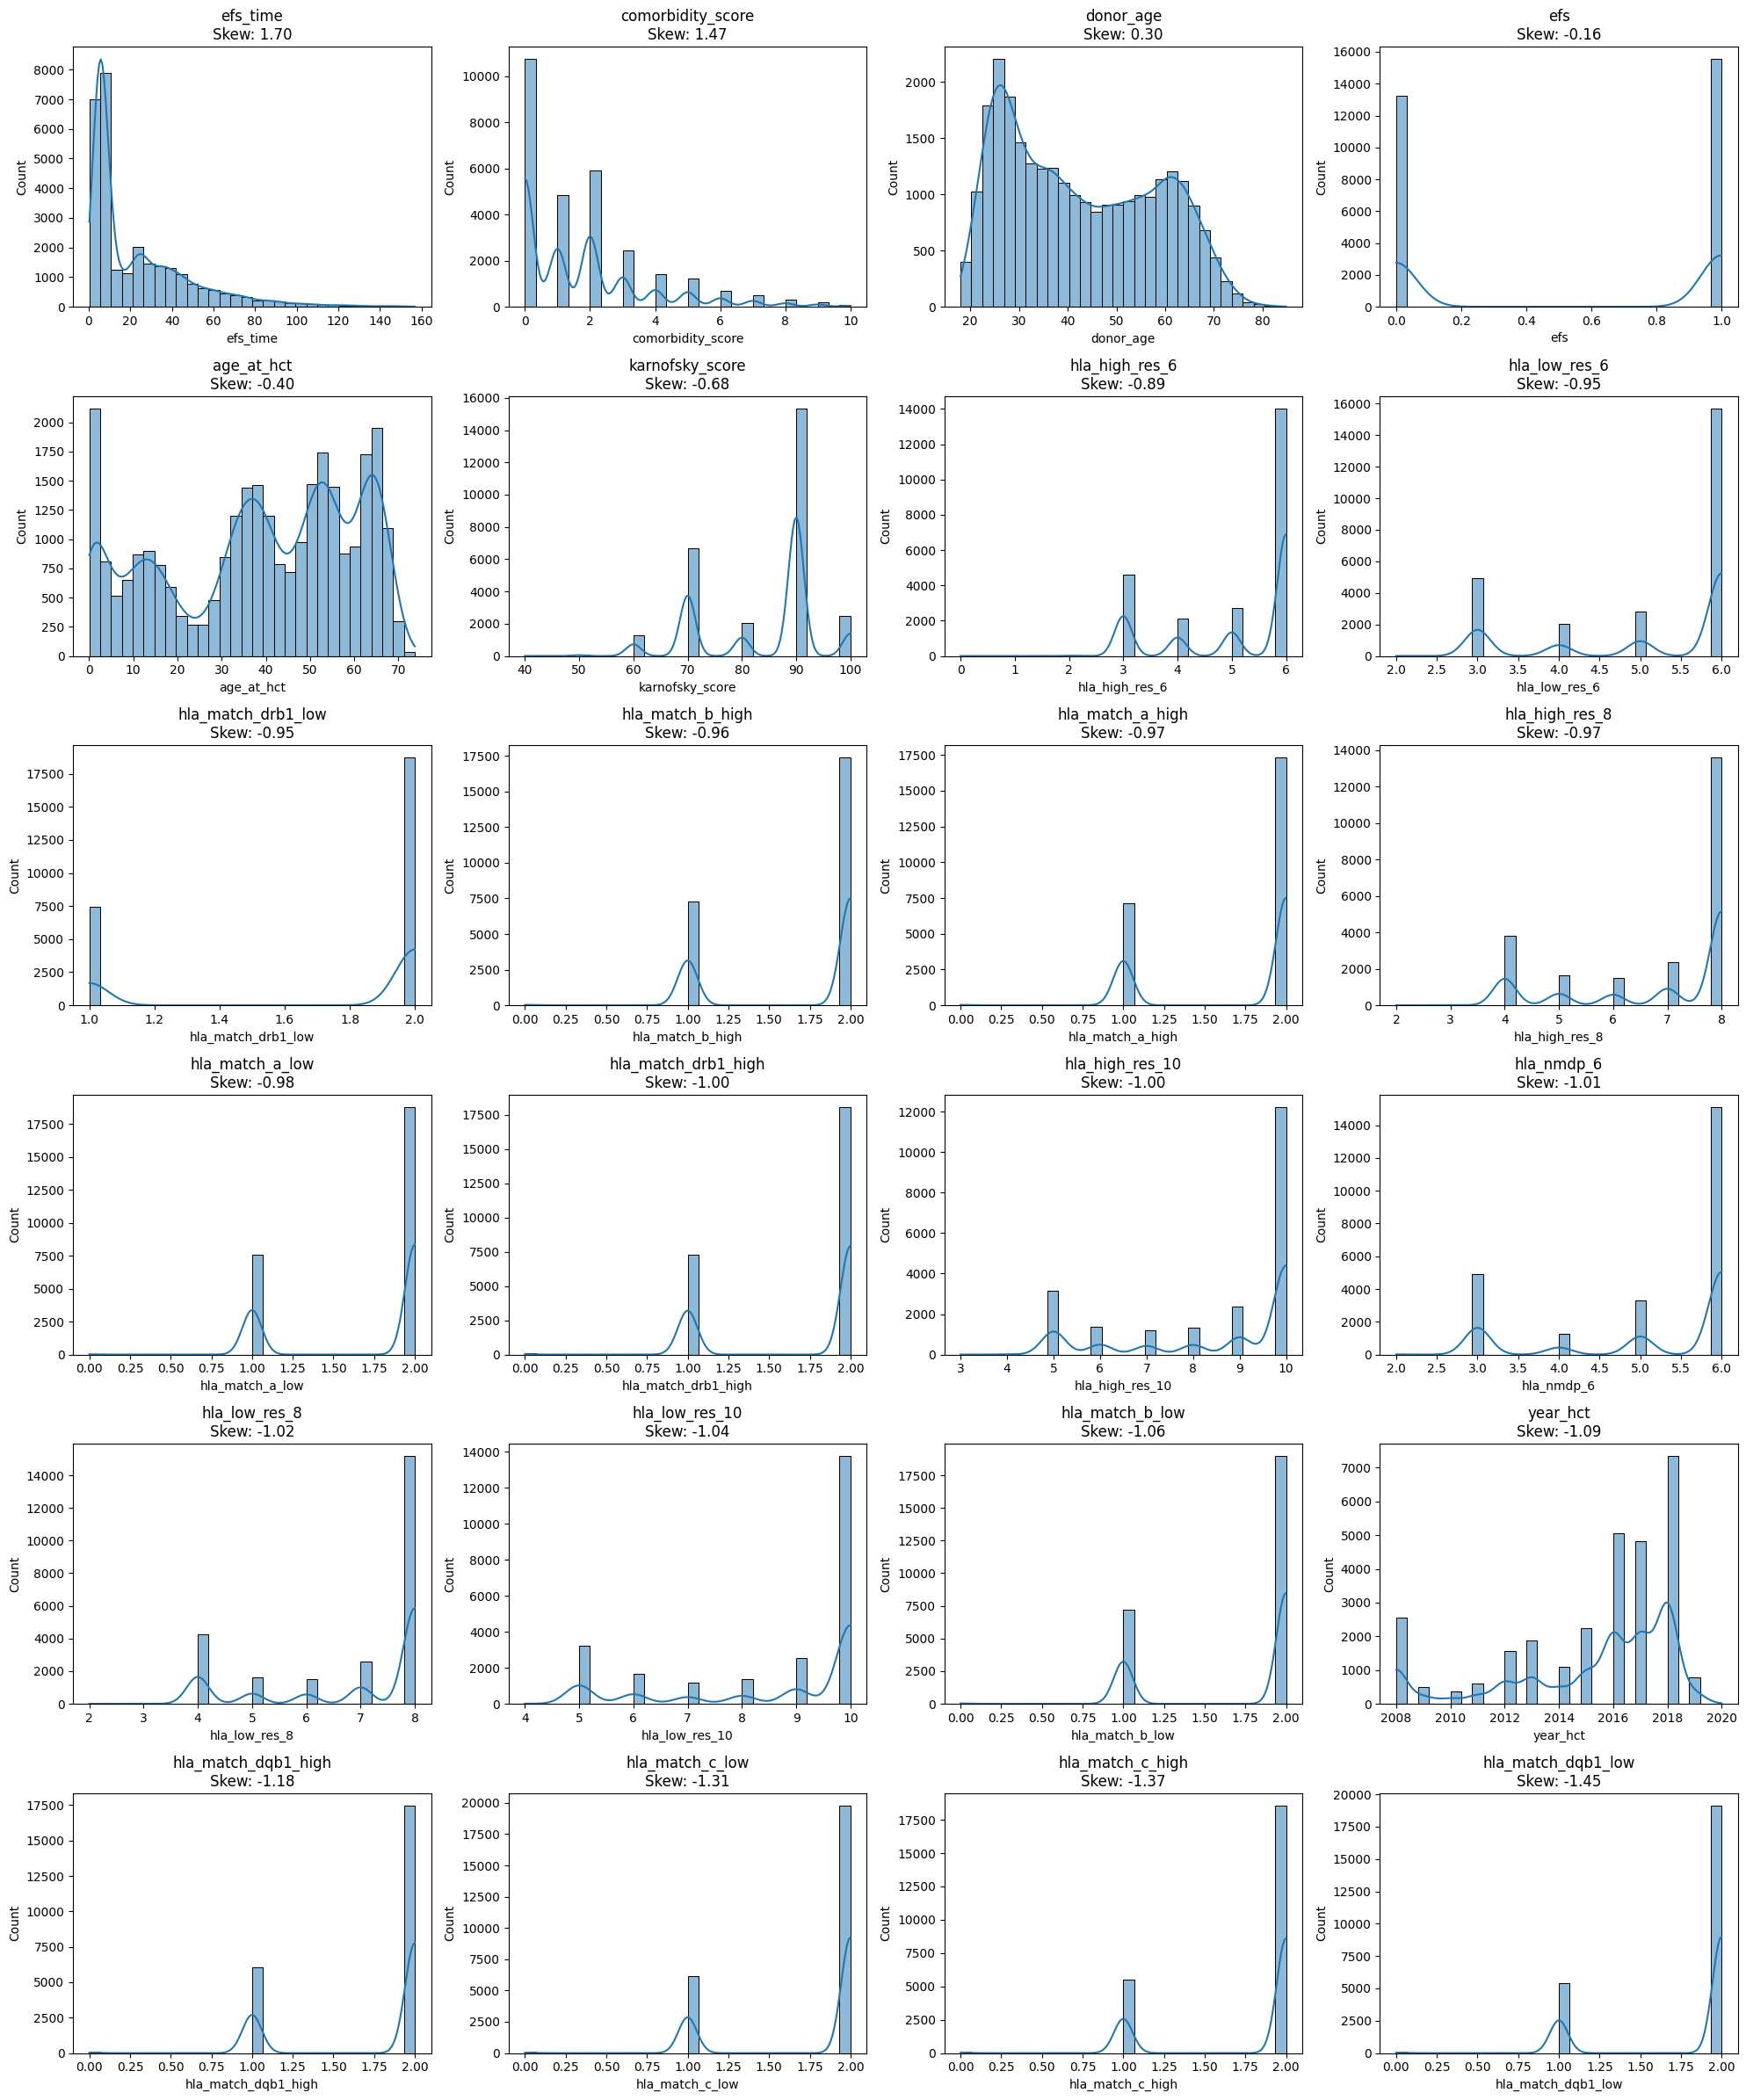

In [ ]:
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axes = axes.flatten()

for i, feature in enumerate(top_skewed):
    sns.histplot(df_train_numeric[feature].dropna(), kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'{feature}\nSkew: {skewness[feature]:.2f}')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

* efs_time = +1.70 – Strong right skew; survival time is long for a few patients

* comorbidity_score = +1.47 – Most patients have low comorbidities; a few have very high scores

* donor_age = +0.29 – Mild right skew, likely centered around adult donors

* karnofsky_score = -0.68 – More patients have higher functional scores (closer to 100)

* age_at_hct = -0.40 – Slight concentration toward older transplant recipients

* efs = -0.15 – Almost symmetric, as expected for a binary (0/1) label

* Highly left-skewed:
- hla_high_res_6/8/10, hla_low_res_6/8/10,
- hla_match_drb1_high/low, hla_match_b/a/c_*,
- hla_match_dqb1_*, year_hct
- Most patients are recent and well matched; only a few have low match scores

In [ ]:
def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((series < lower_bound) | (series > upper_bound)).sum()

outlier_counts = df_train_numeric.apply(count_outliers).sort_values(ascending=False)

In [ ]:
top_outliers = outlier_counts.index.tolist()
num_features = len(top_outliers)

In [ ]:
print(outlier_counts)

hla_match_c_low        6218
hla_match_c_high       5615
hla_match_dqb1_low     5475
comorbidity_score      1759
efs_time               1154
hla_high_res_8            2
hla_low_res_8             1
hla_high_res_6            1
hla_nmdp_6                0
hla_match_dqb1_high       0
hla_high_res_10           0
hla_low_res_6             0
donor_age                 0
hla_match_drb1_low        0
year_hct                  0
hla_match_a_high          0
hla_match_a_low           0
age_at_hct                0
hla_match_b_low           0
hla_match_b_high          0
karnofsky_score           0
hla_match_drb1_high       0
hla_low_res_10            0
efs                       0
dtype: int64


In [ ]:
cols = 4
rows = math.ceil(num_features / cols)

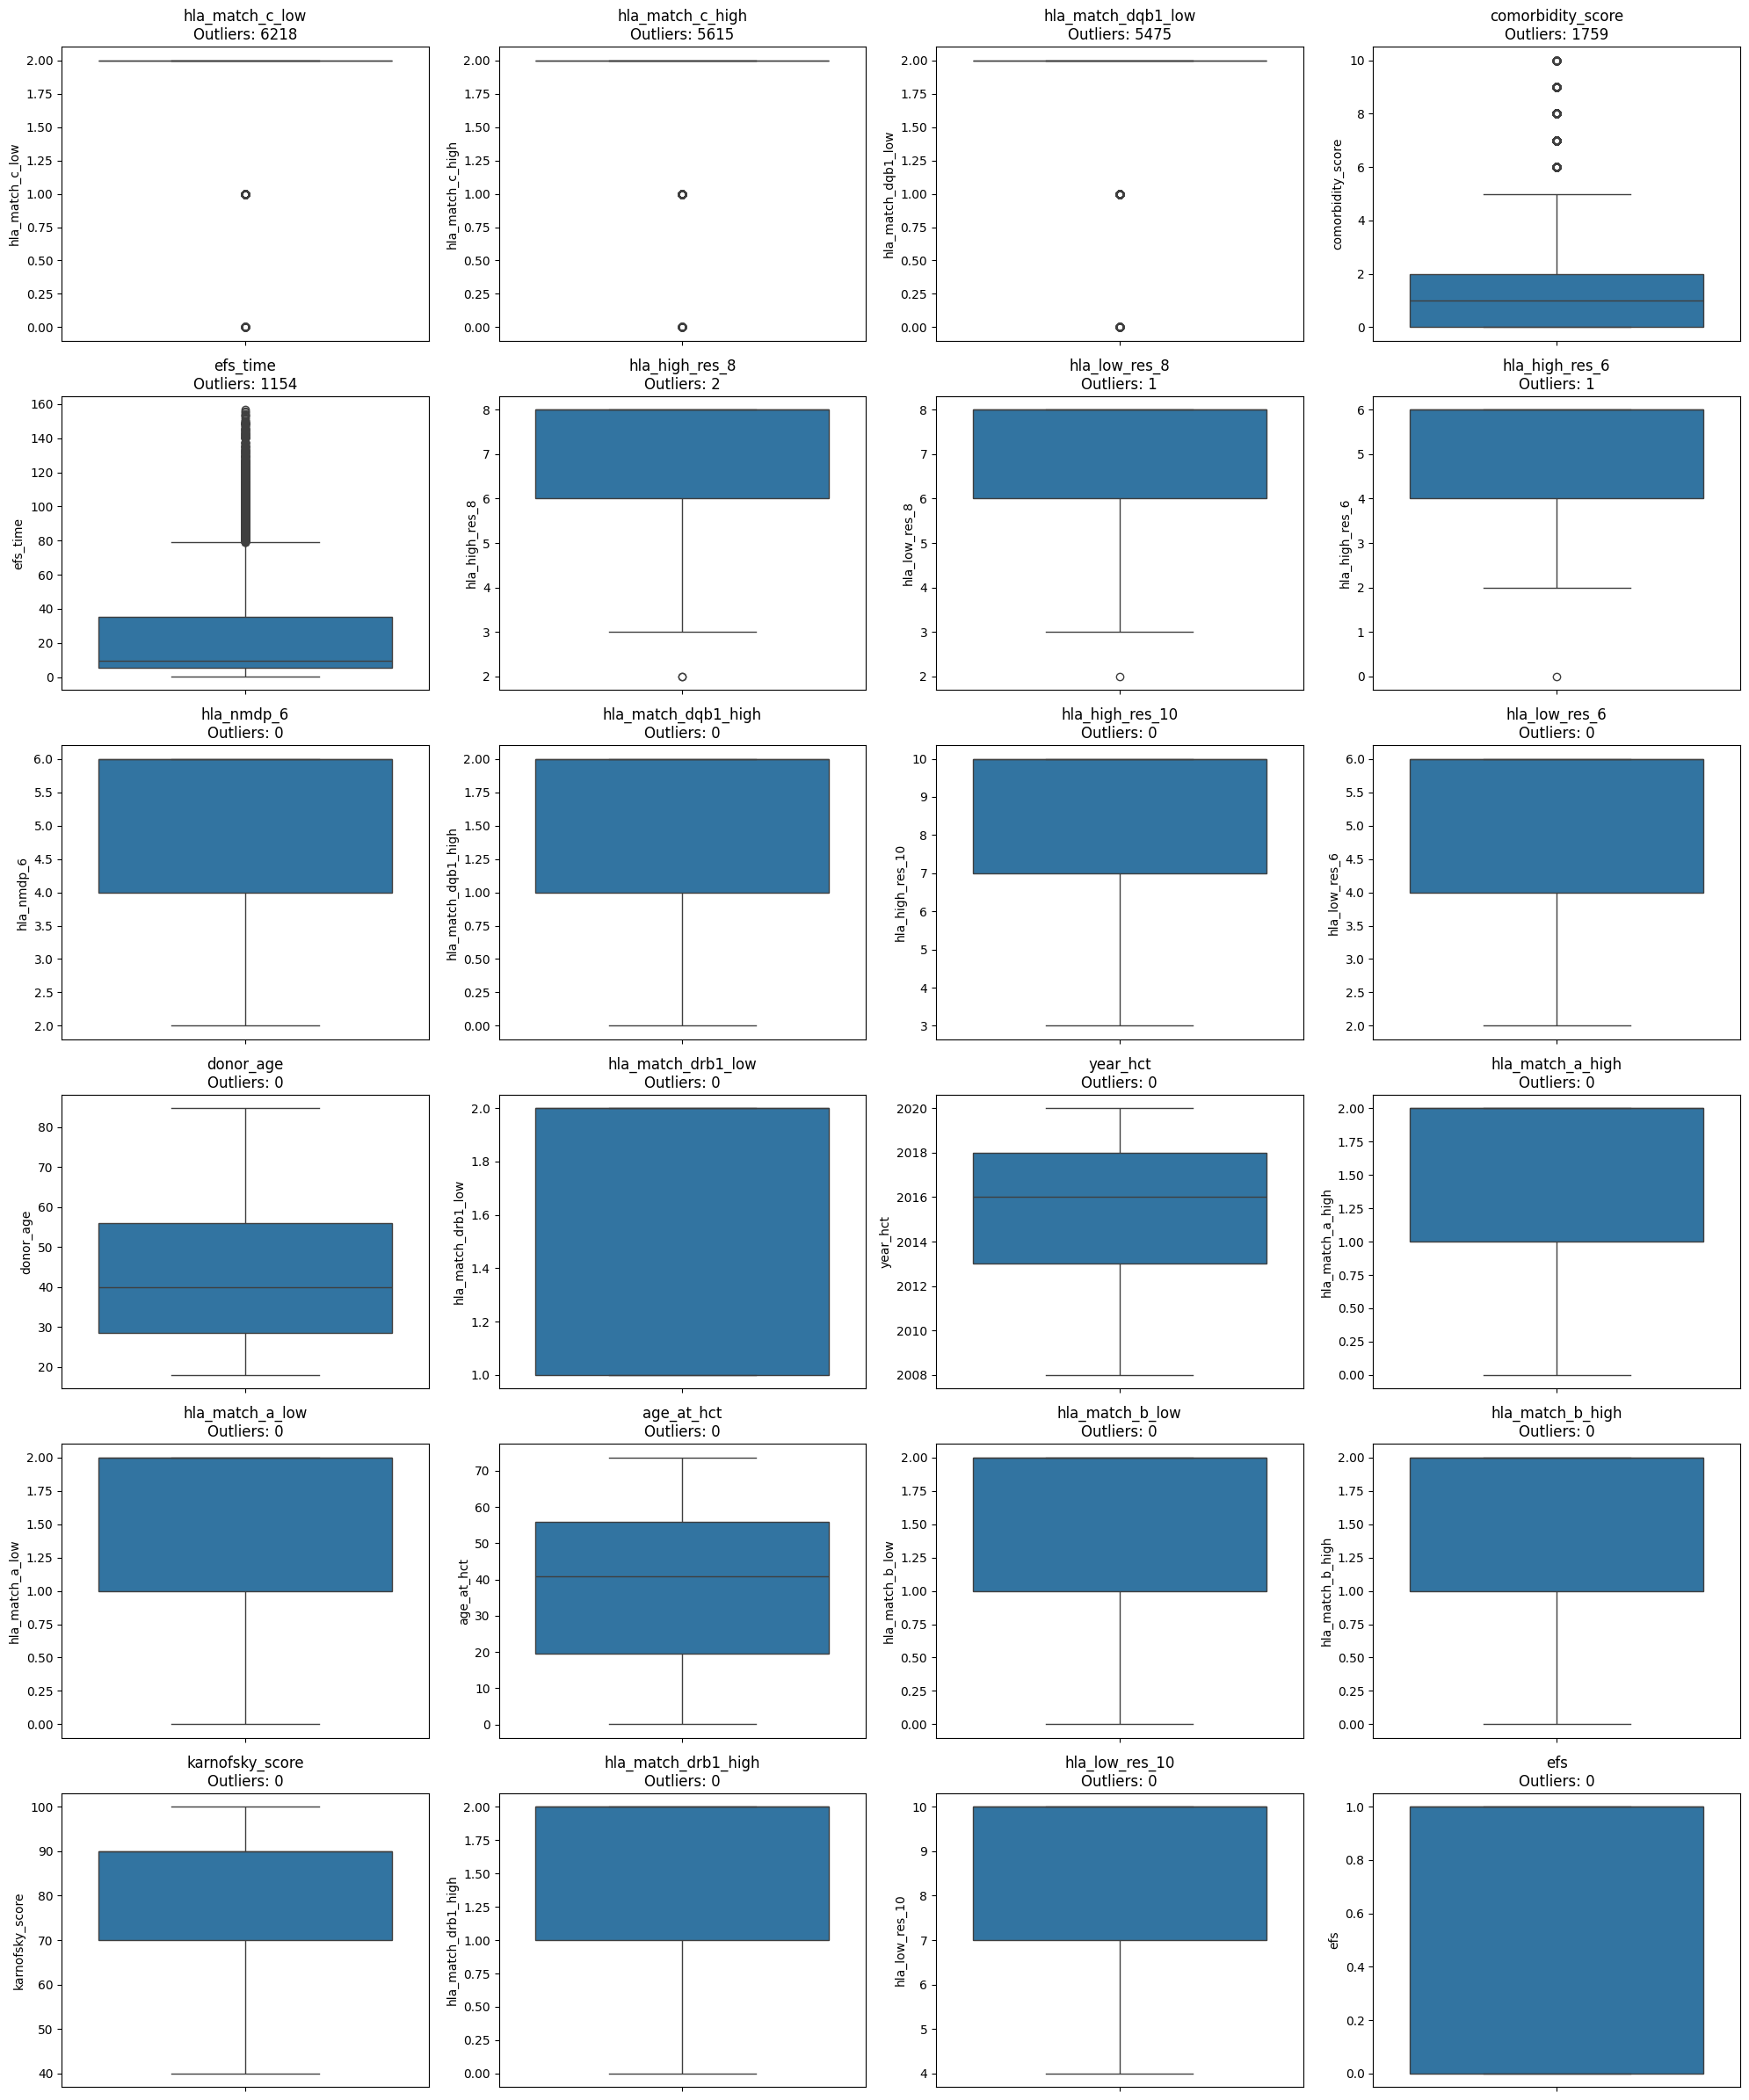

In [ ]:
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axes = axes.flatten()

for i, feature in enumerate(top_outliers):
    sns.boxplot(y=df_train_numeric[feature], ax=axes[i])
    axes[i].set_title(f'{feature}\nOutliers: {outlier_counts[feature]}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- hla_match_c_low (6218), hla_match_c_high (5615), and hla_match_dqb1_low (5475) have the highest number of outliers, consistent with their strong negative skew.
- comorbidity_score shows 1759 outliers — a few patients have significantly higher comorbidities.
- efs_time also contains outliers (1154) — survival times are long for some patients.
- Many HLA features and clinical fields like donor_age, karnofsky_score have zero or negligible outliers.

In [ ]:
df_train['ethnicity'].value_counts(dropna=False)

ethnicity
Not Hispanic or Latino      24482
Hispanic or Latino           3347
NaN                           587
Non-resident of the U.S.      384
Name: count, dtype: int64

In [ ]:
df_train['ethnicity'] = df_train['ethnicity'].fillna('Unknown')

In [ ]:
df_train['ethnicity'].value_counts(dropna=False)

ethnicity
Not Hispanic or Latino      24482
Hispanic or Latino           3347
Unknown                       587
Non-resident of the U.S.      384
Name: count, dtype: int64



---

Two target variables
- efs → binary classification
- efs_time → time-to-event regression

Protected groups (race_group, ethnicity) to ensure fairness.

In [ ]:
X = df_train.drop(columns=["efs", "efs_time"])
y_cls = df_train["efs"]
y_reg = df_train["efs_time"]
protected_cols = ["race_group", "ethnicity"]

In [ ]:
X_train, X_test, y_cls_train, y_cls_test, y_reg_train, y_reg_test = train_test_split(
    X, y_cls, y_reg, test_size=0.2, random_state=42, stratify=y_cls
)

In [ ]:
X_train_lgbm = X_train.copy()
X_test_lgbm = X_test.copy()

for col in X_train_lgbm.select_dtypes(include='object').columns:
    X_train_lgbm[col] = X_train_lgbm[col].fillna('Unknown').astype('category')
    X_test_lgbm[col] = X_test_lgbm[col].fillna('Unknown').astype('category')

In [ ]:
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

for col in X_train_rf.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X_train_rf[col] = le.fit_transform(X_train_rf[col].fillna('Unknown'))
    X_test_rf[col] = le.transform(X_test_rf[col].fillna('Unknown'))

In [ ]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_rf, y_cls_train)

rf_feat_imp = pd.DataFrame({
    'Feature': X_train_rf.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

In [ ]:
cls_model = LGBMClassifier(n_estimators=200, random_state=42)
cls_model.fit(X_train_lgbm, y_cls_train)
y_cls_pred = cls_model.predict_proba(X_test_lgbm)[:, 1]

[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617


In [ ]:
reg_model = LGBMRegressor(n_estimators=200, random_state=42)
reg_model.fit(X_train_lgbm, y_reg_train)
y_reg_pred = reg_model.predict(X_test_lgbm)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046


In [ ]:
print("AUC:", roc_auc_score(y_cls_test, y_cls_pred))
print("Brier Score:", brier_score_loss(y_cls_test, y_cls_pred))
print("RMSE:", mean_squared_error(y_reg_test, y_reg_pred))
print("Concordance Index:", concordance_index(y_reg_test, y_reg_pred))

AUC: 0.7597492225223708
Brier Score: 0.19800324953252155
RMSE: 501.5187674225739
Concordance Index: 0.6315163107079326


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


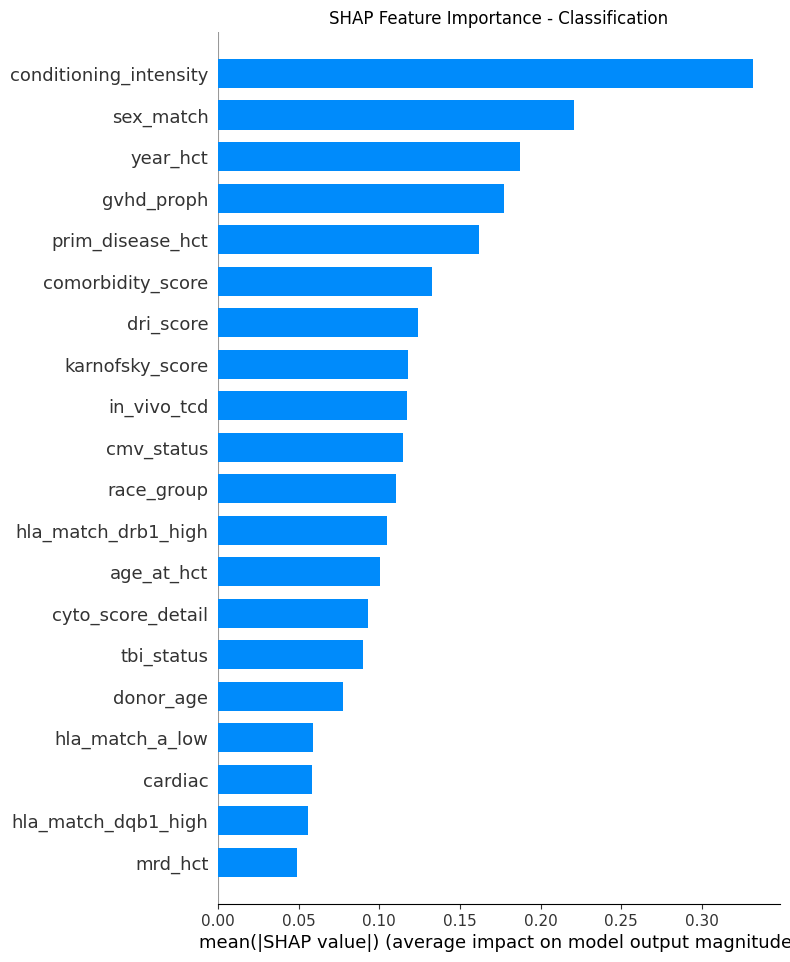

In [ ]:
explainer_cls = shap.TreeExplainer(cls_model, feature_perturbation="tree_path_dependent")
shap_vals_cls = explainer_cls.shap_values(X_test_lgbm)

shap.summary_plot(shap_vals_cls, X_test_lgbm, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - Classification")
plt.show()

In [ ]:
print(type(shap_vals_cls), np.shape(shap_vals_cls))

<class 'numpy.ndarray'> (5760, 57)


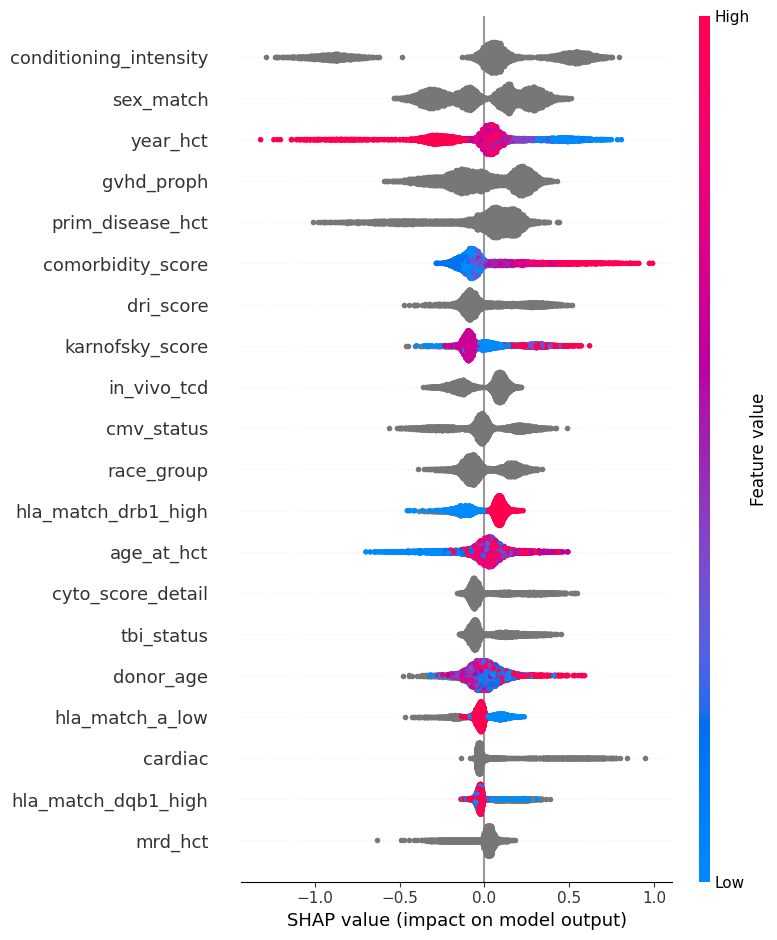

In [ ]:
shap.summary_plot(shap_vals_cls, X_test_lgbm)

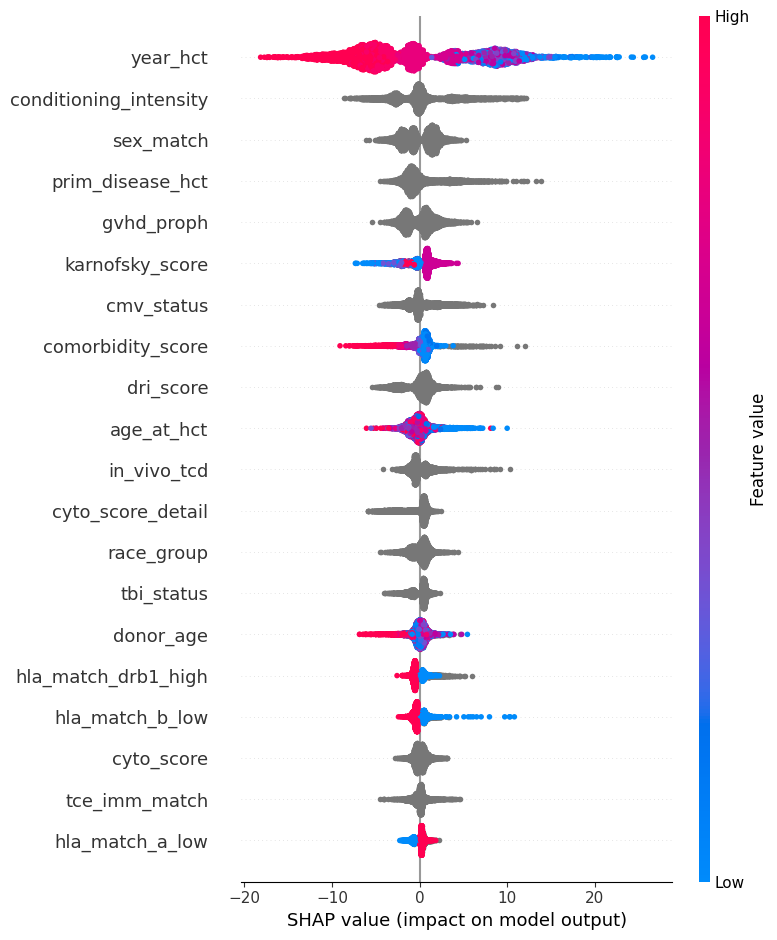

In [ ]:
explainer_reg = shap.Explainer(reg_model)
shap_vals_reg = explainer_reg(X_test_lgbm)
shap.summary_plot(shap_vals_reg, X_test_lgbm)

/tmp/ipython-input-355963196.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rf_feat_imp.head(20), x='Importance', y='Feature', palette='viridis')


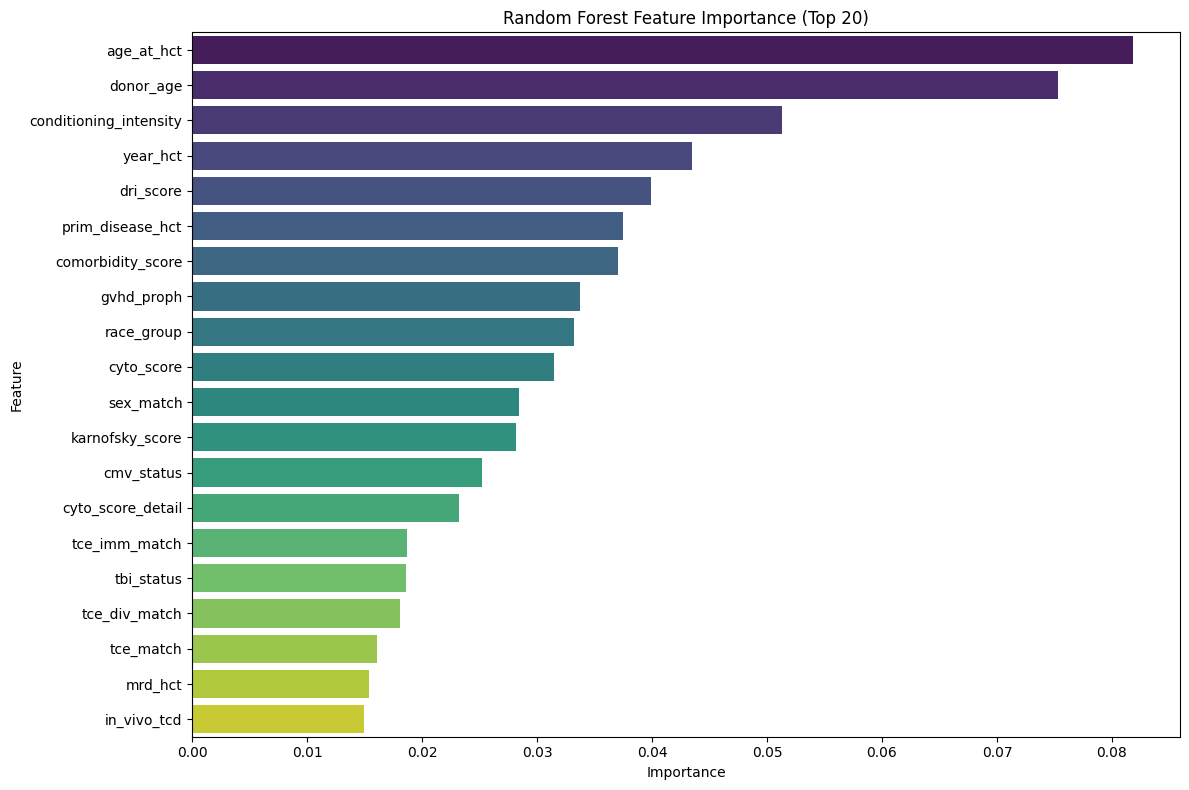

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(data=rf_feat_imp.head(20), x='Importance', y='Feature', palette='viridis')
plt.title('Random Forest Feature Importance (Top 20)')
plt.tight_layout()
plt.show()

* SHAP = Explain how predictions are formed (local + global interpretation)
* RF = Importance for model structure insight (how often splits happen)

**Partial Dependence Plot** to understand how a feature (or two) affects the predictions made by a model, on average, while marginalizing over all other features. Therefore , considering the top 3 features from RF Importance and Shap.

[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 830
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617


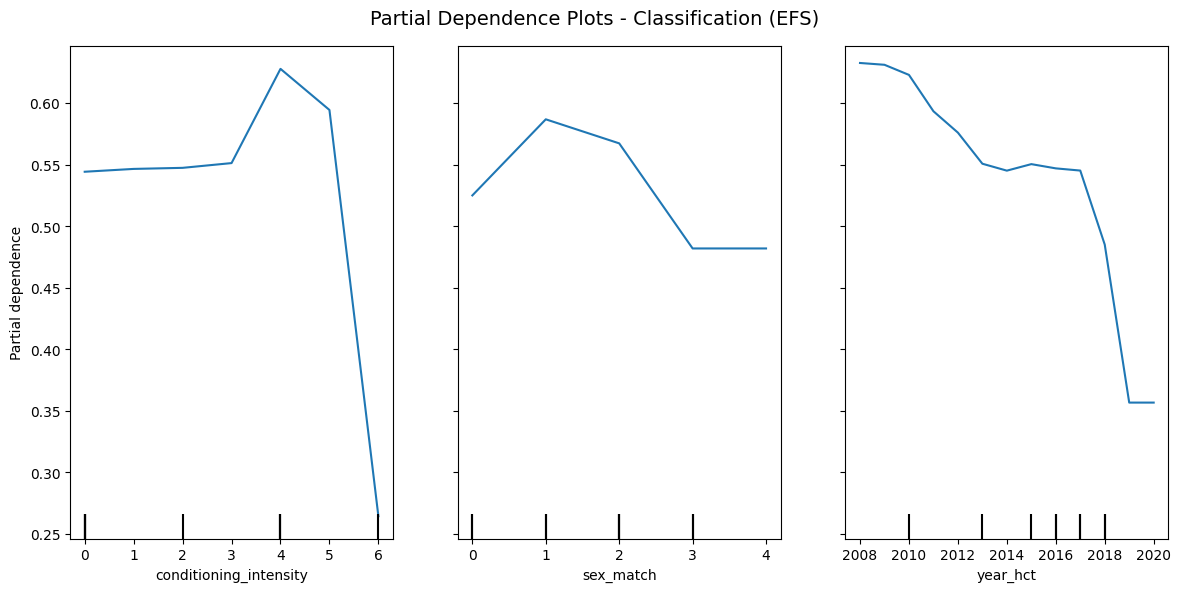

In [ ]:
X_train_pdp = X_train.copy()
X_test_pdp = X_test.copy()

for col in X_train_pdp.select_dtypes(['object', 'category']).columns:
    le = LabelEncoder()
    X_train_pdp[col] = le.fit_transform(X_train_pdp[col].astype(str))
    X_test_pdp[col] = le.transform(X_test_pdp[col].astype(str))

cls_model_pdp = LGBMClassifier(n_estimators=100, random_state=42)
cls_model_pdp.fit(X_train_pdp, y_cls_train)

features_cls = ['conditioning_intensity', 'sex_match', 'year_hct']

fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(cls_model_pdp, X_test_pdp, features=features_cls, ax=ax)
plt.suptitle("Partial Dependence Plots - Classification (EFS)", fontsize=14)
plt.tight_layout()
plt.show()

* conditioning_intensity - High intensity may lead to lower EFS probability
* sex_match - Gender match likely improves outcomes
* year_hct - Possibly due to more complex cases or updated protocols

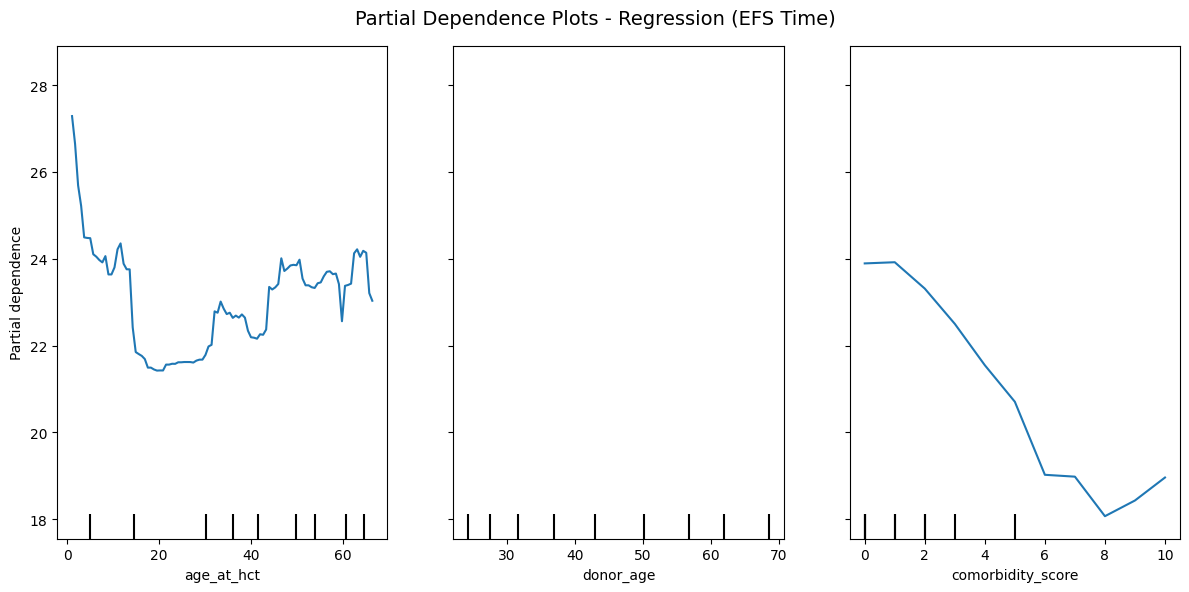

In [ ]:
features_reg = ['age_at_hct', 'donor_age', 'comorbidity_score']
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(reg_model, X_test_lgbm, features=features_reg, ax=ax)
plt.suptitle("Partial Dependence Plots - Regression (EFS Time)", fontsize=14)
plt.tight_layout()
plt.show()

* age_at_hct - Younger patients have slightly better EFS
* donor_age - Might need more binning or feature engineering
* comorbidity_score - Higher comorbidity = shorter EFS time

In [ ]:
def fairness_eval(df, y_true, y_pred, group_col, task_type='classification'):
    metrics = []
    for group in df[group_col].dropna().unique():
        idx = df[group_col] == group
        if task_type == 'classification':
            auc = roc_auc_score(y_true[idx], y_pred[idx])
            brier = brier_score_loss(y_true[idx], y_pred[idx])
            metrics.append((group, auc, brier))
        else:
            rmse = mean_squared_error(y_true[idx], y_pred[idx])
            metrics.append((group, rmse))
    return metrics

In [ ]:
df_test = X_test.copy()
df_test["race_group"] = df_train.loc[X_test.index, "race_group"].values
df_test["ethnicity"] = df_train.loc[X_test.index, "ethnicity"].values

In [ ]:
cls_race_eval = fairness_eval(df_test, y_cls_test, y_cls_pred, "race_group", "classification")
cls_eth_eval = fairness_eval(df_test, y_cls_test, y_cls_pred, "ethnicity", "classification")

In [ ]:
reg_race_eval = fairness_eval(df_test, y_reg_test, y_reg_pred, "race_group", "regression")
reg_eth_eval = fairness_eval(df_test, y_reg_test, y_reg_pred, "ethnicity", "regression")

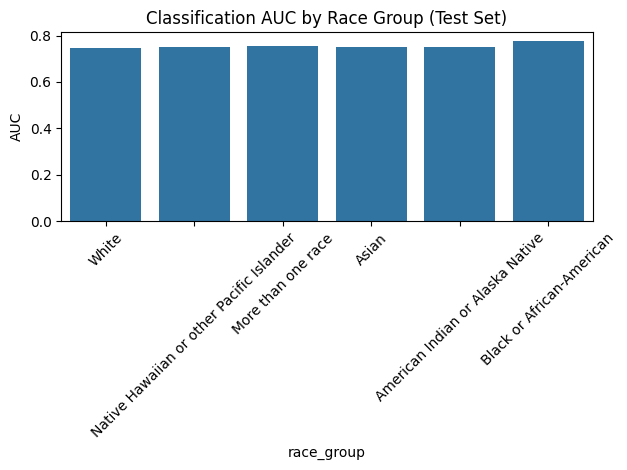

In [ ]:
race_df = pd.DataFrame(cls_race_eval, columns=["race_group", "AUC", "Brier"])
sns.barplot(x="race_group", y="AUC", data=race_df)
plt.title("Classification AUC by Race Group (Test Set)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* The AUC values are very close across all race groups (difference < 0.03), indicating no major disparity in model performance by race.
* The model performs consistently across demographics, which is crucial in clinical settings to avoid bias or systemic disadvantage.

In [ ]:
calib_df = pd.DataFrame({
    'y_true': y_cls_test,
    'y_prob': y_cls_pred,
    'race_group': X_test['race_group'].values
})

In [ ]:
race_groups = calib_df['race_group'].unique()
colors = cm.tab10.colors

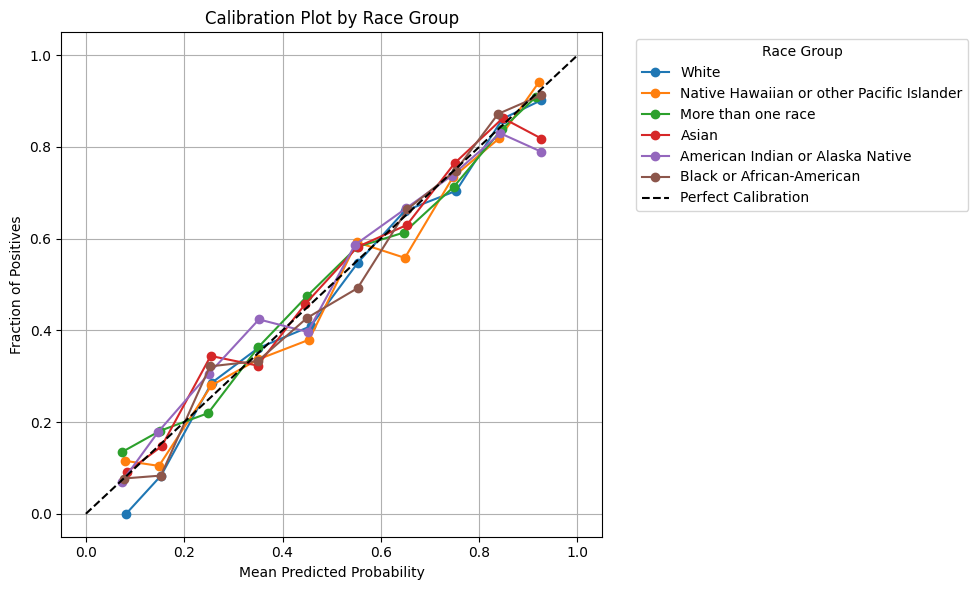

In [ ]:
plt.figure(figsize=(10, 6))
for i, group in enumerate(race_groups):
    group_data = calib_df[calib_df['race_group'] == group]

    prob_true, prob_pred = calibration_curve(
        group_data['y_true'], group_data['y_prob'], n_bins=10, strategy='uniform'
    )

    plt.plot(prob_pred, prob_true, marker='o', label=group, color=colors[i % len(colors)])

plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")

plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Plot by Race Group")
plt.legend(title="Race Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

* LightGBM classifier is fairly well-calibrated across race groups.
* There are no race groups with extreme deviations from the expected diagonal

In [ ]:
brier_scores = {}

for group in calib_df['race_group'].unique():
    group_data = calib_df[calib_df['race_group'] == group]
    score = brier_score_loss(group_data['y_true'], group_data['y_prob'])
    brier_scores[group] = score

brier_df = pd.DataFrame(list(brier_scores.items()), columns=['Race Group', 'Brier Score'])
brier_df = brier_df.sort_values('Brier Score', ascending=True)

print(brier_df)

                                  Race Group  Brier Score
5                  Black or African-American     0.191222
0                                      White     0.193158
3                                      Asian     0.198274
2                         More than one race     0.200008
1  Native Hawaiian or other Pacific Islander     0.202272
4           American Indian or Alaska Native     0.202731


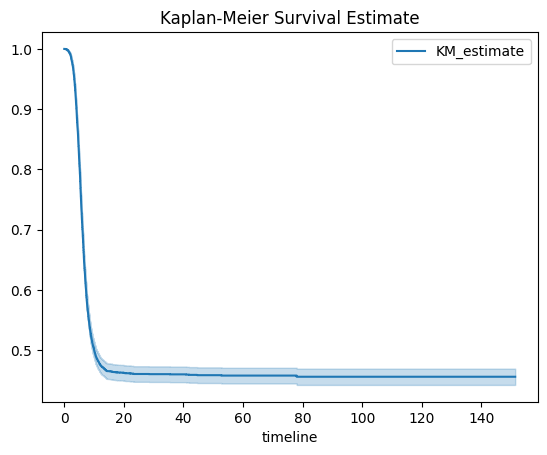

In [ ]:
kmf = KaplanMeierFitter()
kmf.fit(y_reg_test, event_observed=y_cls_test)
kmf.plot_survival_function()
plt.title("Kaplan-Meier Survival Estimate")
plt.show()

The Kaplan-Meier survival curve reveals a sharp decline in survival probability during the initial ~15 time units, indicating a period of high early mortality or event occurrence. Beyond this phase, the curve begins to plateau around 20–30 units, suggesting that individuals who survive the early high-risk period tend to have more stable, longer-term outcomes. Ultimately, the survival probability stabilizes at approximately 0.45, meaning that around 45% of the population remains event-free by the end of the follow-up period.

In [ ]:
platt_clf = CalibratedClassifierCV(estimator=cls_model, method='sigmoid', cv=5)
platt_clf.fit(X_train_rf, y_cls_train)
y_pred_proba_platt = platt_clf.predict_proba(X_test_rf)[:, 1]

print("Platt (sigmoid) Calibration:")
print("AUC:", roc_auc_score(y_cls_test, y_pred_proba_platt))
print("Brier Score:", brier_score_loss(y_cls_test, y_pred_proba_platt))

[LightGBM] [Info] Number of positive: 9940, number of negative: 8492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 830
[LightGBM] [Info] Number of data points in the train set: 18432, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539280 -> initscore=0.157442
[LightGBM] [Info] Start training from score 0.157442
[LightGBM] [Info] Number of positive: 9941, number of negative: 8491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 830
[LightGBM] [Info] Number of data points in the train set: 18432, number of used features: 57
[LightGBM] [Info] [binary:

In [ ]:
isotonic_clf = CalibratedClassifierCV(estimator=cls_model, method='isotonic', cv=5)
isotonic_clf.fit(X_train_rf, y_cls_train)
y_pred_proba_iso = isotonic_clf.predict_proba(X_test_rf)[:, 1]

print("\nIsotonic Calibration:")
print("AUC:", roc_auc_score(y_cls_test, y_pred_proba_iso))
print("Brier Score:", brier_score_loss(y_cls_test, y_pred_proba_iso))

[LightGBM] [Info] Number of positive: 9940, number of negative: 8492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 830
[LightGBM] [Info] Number of data points in the train set: 18432, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539280 -> initscore=0.157442
[LightGBM] [Info] Start training from score 0.157442
[LightGBM] [Info] Number of positive: 9941, number of negative: 8491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 830
[LightGBM] [Info] Number of data points in the train set: 18432, number of used features: 57
[LightGBM] [Info] [binary:

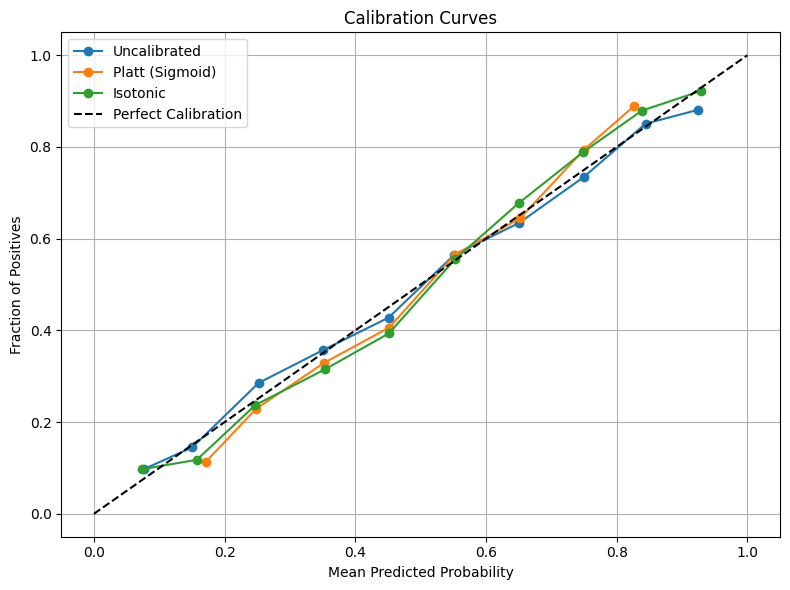

In [ ]:
plt.figure(figsize=(8, 6))

for probs, label in zip(
    [y_cls_pred, y_pred_proba_platt, y_pred_proba_iso],
    ['Uncalibrated', 'Platt (Sigmoid)', 'Isotonic']
):
    prob_true, prob_pred = calibration_curve(y_cls_test, probs, n_bins=10, strategy='uniform')
    plt.plot(prob_pred, prob_true, marker='o', label=label)

plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
    }
    model = LGBMClassifier(**params)
    model.fit(X_train_lgbm, y_cls_train)
    preds = model.predict_proba(X_test_lgbm)[:, 1]
    return roc_auc_score(y_cls_test, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2025-08-07 16:32:35,553] A new study created in memory with name: no-name-05ee42dc-d549-41bf-9a53-9d00af84a2fa
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617


[I 2025-08-07 16:32:41,407] Trial 0 finished with value: 0.7343385993320171 and parameters: {'n_estimators': 328, 'max_depth': 8, 'learning_rate': 0.00101657605001812}. Best is trial 0 with value: 0.7343385993320171.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617


[I 2025-08-07 16:32:46,103] Trial 1 finished with value: 0.7391849452963393 and parameters: {'n_estimators': 475, 'max_depth': 10, 'learning_rate': 0.17779398023130613}. Best is trial 1 with value: 0.7391849452963393.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617


[I 2025-08-07 16:32:54,124] Trial 2 finished with value: 0.7583402035392519 and parameters: {'n_estimators': 404, 'max_depth': 9, 'learning_rate': 0.007997757707517901}. Best is trial 2 with value: 0.7583402035392519.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:32:55,404] Trial 3 finished with value: 0.732950142442539 and parameters: {'n_estimators': 122, 'max_depth': 4, 'learning_rate': 0.0023698097309957636}. Best is trial 2 with value: 0.7583402035392519.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617


[I 2025-08-07 16:32:58,265] Trial 4 finished with value: 0.7534873068194335 and parameters: {'n_estimators': 158, 'max_depth': 7, 'learning_rate': 0.015397006993862157}. Best is trial 2 with value: 0.7583402035392519.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617


[I 2025-08-07 16:33:09,339] Trial 5 finished with value: 0.7383112079544611 and parameters: {'n_estimators': 406, 'max_depth': 10, 'learning_rate': 0.0013217699124225843}. Best is trial 2 with value: 0.7583402035392519.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:33:11,150] Trial 6 finished with value: 0.7331185211208489 and parameters: {'n_estimators': 149, 'max_depth': 5, 'learning_rate': 0.0018270554671227244}. Best is trial 2 with value: 0.7583402035392519.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617


[I 2025-08-07 16:33:15,074] Trial 7 finished with value: 0.7599097160320278 and parameters: {'n_estimators': 207, 'max_depth': 7, 'learning_rate': 0.01757663281380029}. Best is trial 7 with value: 0.7599097160320278.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617


[I 2025-08-07 16:33:23,035] Trial 8 finished with value: 0.762950115754276 and parameters: {'n_estimators': 441, 'max_depth': 6, 'learning_rate': 0.01435768730953141}. Best is trial 8 with value: 0.762950115754276.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617


[I 2025-08-07 16:33:26,044] Trial 9 finished with value: 0.7383676172379006 and parameters: {'n_estimators': 369, 'max_depth': 8, 'learning_rate': 0.0015918233925436688}. Best is trial 8 with value: 0.762950115754276.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:33:28,150] Trial 10 finished with value: 0.7658431234778591 and parameters: {'n_estimators': 491, 'max_depth': 3, 'learning_rate': 0.08392861280326973}. Best is trial 10 with value: 0.7658431234778591.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:33:30,483] Trial 11 finished with value: 0.767113848733836 and parameters: {'n_estimators': 494, 'max_depth': 3, 'learning_rate': 0.08924151134188314}. Best is trial 11 with value: 0.767113848733836.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:33:33,767] Trial 12 finished with value: 0.7637036952569133 and parameters: {'n_estimators': 499, 'max_depth': 3, 'learning_rate': 0.13166811381578125}. Best is trial 11 with value: 0.767113848733836.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-08-07 16:33:35,378] Trial 13 finished with value: 0.7671076619092008 and parameters: {'n_estimators': 245, 'max_depth': 3, 'learning_rate': 0.06826888484498164}. Best is trial 11 with value: 0.767113848733836.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:33:36,889] Trial 14 finished with value: 0.765873329739314 and parameters: {'n_estimators': 259, 'max_depth': 4, 'learning_rate': 0.04713457575149936}. Best is trial 11 with value: 0.767113848733836.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:33:38,672] Trial 15 finished with value: 0.7624525009571381 and parameters: {'n_estimators': 257, 'max_depth': 5, 'learning_rate': 0.04806033550313473}. Best is trial 11 with value: 0.767113848733836.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:33:40,082] Trial 16 finished with value: 0.7644781401289091 and parameters: {'n_estimators': 313, 'max_depth': 3, 'learning_rate': 0.2387581267587628}. Best is trial 11 with value: 0.767113848733836.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:33:41,435] Trial 17 finished with value: 0.7653207613821803 and parameters: {'n_estimators': 229, 'max_depth': 4, 'learning_rate': 0.05250586501873205}. Best is trial 11 with value: 0.767113848733836.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:33:43,557] Trial 18 finished with value: 0.7580121805232938 and parameters: {'n_estimators': 333, 'max_depth': 5, 'learning_rate': 0.10301026528066745}. Best is trial 11 with value: 0.767113848733836.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-07 16:33:46,661] Trial 19 finished with value: 0.7634838810169297 and parameters: {'n_estimators': 273, 'max_depth': 6, 'learning_rate': 0.028673814103167126}. Best is trial 11 with value: 0.767113848733836.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:33:48,239] Trial 20 finished with value: 0.7454291496973795 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.007203343357360132}. Best is trial 11 with value: 0.767113848733836.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:33:49,517] Trial 21 finished with value: 0.7662931846425057 and parameters: {'n_estimators': 265, 'max_depth': 3, 'learning_rate': 0.054193610741261625}. Best is trial 11 with value: 0.767113848733836.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:33:50,836] Trial 22 finished with value: 0.7673723609553622 and parameters: {'n_estimators': 280, 'max_depth': 3, 'learning_rate': 0.07709407842714983}. Best is trial 22 with value: 0.7673723609553622.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:33:52,425] Trial 23 finished with value: 0.7673665380615878 and parameters: {'n_estimators': 354, 'max_depth': 3, 'learning_rate': 0.09748981506712293}. Best is trial 22 with value: 0.7673723609553622.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:33:54,407] Trial 24 finished with value: 0.7464223170167763 and parameters: {'n_estimators': 378, 'max_depth': 4, 'learning_rate': 0.2385664162383242}. Best is trial 22 with value: 0.7673723609553622.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:33:57,496] Trial 25 finished with value: 0.7626626103741646 and parameters: {'n_estimators': 451, 'max_depth': 5, 'learning_rate': 0.029321443829687512}. Best is trial 22 with value: 0.7673723609553622.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:33:59,832] Trial 26 finished with value: 0.7664757566243908 and parameters: {'n_estimators': 356, 'max_depth': 3, 'learning_rate': 0.12677995916364382}. Best is trial 22 with value: 0.7673723609553622.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:34:02,165] Trial 27 finished with value: 0.7645238741070957 and parameters: {'n_estimators': 284, 'max_depth': 4, 'learning_rate': 0.03383835535917713}. Best is trial 22 with value: 0.7673723609553622.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:34:03,601] Trial 28 finished with value: 0.7609557746365423 and parameters: {'n_estimators': 304, 'max_depth': 3, 'learning_rate': 0.2711937385179164}. Best is trial 22 with value: 0.7673723609553622.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:34:05,756] Trial 29 finished with value: 0.7491611393656248 and parameters: {'n_estimators': 337, 'max_depth': 6, 'learning_rate': 0.16401720304170103}. Best is trial 22 with value: 0.7673723609553622.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:34:08,451] Trial 30 finished with value: 0.7577859368381008 and parameters: {'n_estimators': 414, 'max_depth': 5, 'learning_rate': 0.08109165287144776}. Best is trial 22 with value: 0.7673723609553622.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:34:09,605] Trial 31 finished with value: 0.7661638678765994 and parameters: {'n_estimators': 234, 'max_depth': 3, 'learning_rate': 0.07225583267272583}. Best is trial 22 with value: 0.7673723609553622.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:34:10,621] Trial 32 finished with value: 0.7658962573835506 and parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.11337060762653292}. Best is trial 22 with value: 0.7673723609553622.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:34:12,462] Trial 33 finished with value: 0.7619364469963816 and parameters: {'n_estimators': 293, 'max_depth': 4, 'learning_rate': 0.17623779473856843}. Best is trial 22 with value: 0.7673723609553622.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:34:16,128] Trial 34 finished with value: 0.7633657247974239 and parameters: {'n_estimators': 464, 'max_depth': 4, 'learning_rate': 0.06703310590573457}. Best is trial 22 with value: 0.7673723609553622.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:34:17,071] Trial 35 finished with value: 0.7542616303811424 and parameters: {'n_estimators': 173, 'max_depth': 3, 'learning_rate': 0.022021618123113852}. Best is trial 22 with value: 0.7673723609553622.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617


[I 2025-08-07 16:34:20,705] Trial 36 finished with value: 0.7606887706949284 and parameters: {'n_estimators': 428, 'max_depth': 9, 'learning_rate': 0.009072956084682868}. Best is trial 22 with value: 0.7673723609553622.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:34:22,134] Trial 37 finished with value: 0.7651312747139382 and parameters: {'n_estimators': 236, 'max_depth': 4, 'learning_rate': 0.0381119254974557}. Best is trial 22 with value: 0.7673723609553622.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:34:23,634] Trial 38 finished with value: 0.7405482909564153 and parameters: {'n_estimators': 315, 'max_depth': 3, 'learning_rate': 0.003106875272349647}. Best is trial 22 with value: 0.7673723609553622.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617


[I 2025-08-07 16:34:26,076] Trial 39 finished with value: 0.7560325179502833 and parameters: {'n_estimators': 383, 'max_depth': 8, 'learning_rate': 0.09352555100988078}. Best is trial 22 with value: 0.7673723609553622.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:34:27,369] Trial 40 finished with value: 0.758478133335533 and parameters: {'n_estimators': 105, 'max_depth': 5, 'learning_rate': 0.1607459214978683}. Best is trial 22 with value: 0.7673723609553622.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:34:29,840] Trial 41 finished with value: 0.7663808919799828 and parameters: {'n_estimators': 356, 'max_depth': 3, 'learning_rate': 0.128931387843817}. Best is trial 22 with value: 0.7673723609553622.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:34:31,490] Trial 42 finished with value: 0.7668822673960165 and parameters: {'n_estimators': 355, 'max_depth': 3, 'learning_rate': 0.06278126620716452}. Best is trial 22 with value: 0.7673723609553622.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:34:33,716] Trial 43 finished with value: 0.7643227416513048 and parameters: {'n_estimators': 403, 'max_depth': 4, 'learning_rate': 0.06245696745883261}. Best is trial 22 with value: 0.7673723609553622.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:34:35,284] Trial 44 finished with value: 0.767680367773971 and parameters: {'n_estimators': 339, 'max_depth': 3, 'learning_rate': 0.08863224967135556}. Best is trial 44 with value: 0.767680367773971.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:34:36,855] Trial 45 finished with value: 0.7648982376526751 and parameters: {'n_estimators': 330, 'max_depth': 3, 'learning_rate': 0.039460235697425086}. Best is trial 44 with value: 0.767680367773971.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-08-07 16:34:38,290] Trial 46 finished with value: 0.7642299392817753 and parameters: {'n_estimators': 247, 'max_depth': 4, 'learning_rate': 0.0866386942659633}. Best is trial 44 with value: 0.767680367773971.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617


[I 2025-08-07 16:34:39,689] Trial 47 finished with value: 0.7449024204313697 and parameters: {'n_estimators': 216, 'max_depth': 7, 'learning_rate': 0.21654077454735227}. Best is trial 44 with value: 0.767680367773971.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617


[I 2025-08-07 16:34:43,494] Trial 48 finished with value: 0.7628254087792741 and parameters: {'n_estimators': 283, 'max_depth': 10, 'learning_rate': 0.018902814050869018}. Best is trial 44 with value: 0.767680367773971.
/tmp/ipython-input-3831899457.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617


[I 2025-08-07 16:34:45,925] Trial 49 finished with value: 0.756449461406588 and parameters: {'n_estimators': 394, 'max_depth': 9, 'learning_rate': 0.10201940412330426}. Best is trial 44 with value: 0.767680367773971.


In [ ]:
print("Best AUC Score:", study.best_value)
print("Best Hyperparameters:", study.best_params)

Best AUC Score: 0.767680367773971
Best Hyperparameters: {'n_estimators': 339, 'max_depth': 3, 'learning_rate': 0.08863224967135556}


In [ ]:
best_params = study.best_params

final_model = LGBMClassifier(**best_params, random_state=42)
final_model.fit(X_train_lgbm, y_cls_train)

[LightGBM] [Info] Number of positive: 12426, number of negative: 10614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539323 -> initscore=0.157617
[LightGBM] [Info] Start training from score 0.157617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

LGBMClassifier(learning_rate=0.08863224967135556, max_depth=3, n_estimators=339,
               random_state=42)

In [ ]:
y_pred_proba_final = final_model.predict_proba(X_test_lgbm)[:, 1]
y_pred_final = final_model.predict(X_test_lgbm)

auc = roc_auc_score(y_cls_test, y_pred_proba_final)
print("Final AUC:", auc)

brier = brier_score_loss(y_cls_test, y_pred_proba_final)
print("Final Brier Score:", brier)

print(classification_report(y_cls_test, y_pred_final))

Final AUC: 0.767680367773971
Final Brier Score: 0.19498621836182062
              precision    recall  f1-score   support

         0.0       0.71      0.60      0.65      2654
         1.0       0.70      0.79      0.74      3106

    accuracy                           0.71      5760
   macro avg       0.71      0.70      0.70      5760
weighted avg       0.71      0.71      0.70      5760



In [ ]:
def reg_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
    }
    model = LGBMRegressor(**params)
    model.fit(X_train_lgbm, y_reg_train)
    preds = model.predict(X_test_lgbm)

    return mean_squared_error(y_reg_test, preds)

In [ ]:
reg_study = optuna.create_study(direction='minimize')
reg_study.optimize(reg_objective, n_trials=50)

[I 2025-08-07 16:43:31,085] A new study created in memory with name: no-name-1c8731af-d96c-43ca-91ad-9b30aff689e4
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046


[I 2025-08-07 16:43:36,308] Trial 0 finished with value: 502.4378781085556 and parameters: {'n_estimators': 491, 'max_depth': 8, 'learning_rate': 0.006929266896432604}. Best is trial 0 with value: 502.4378781085556.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:43:38,525] Trial 1 finished with value: 496.1538695960086 and parameters: {'n_estimators': 470, 'max_depth': 3, 'learning_rate': 0.1628747791464053}. Best is trial 1 with value: 496.1538695960086.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046


[I 2025-08-07 16:43:40,755] Trial 2 finished with value: 497.26372483580167 and parameters: {'n_estimators': 267, 'max_depth': 10, 'learning_rate': 0.04452138612245219}. Best is trial 1 with value: 496.1538695960086.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046


[I 2025-08-07 16:43:44,461] Trial 3 finished with value: 498.1445424249505 and parameters: {'n_estimators': 458, 'max_depth': 7, 'learning_rate': 0.036123824393800866}. Best is trial 1 with value: 496.1538695960086.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:43:45,491] Trial 4 finished with value: 556.568969237489 and parameters: {'n_estimators': 241, 'max_depth': 3, 'learning_rate': 0.0028037104011185733}. Best is trial 1 with value: 496.1538695960086.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046


[I 2025-08-07 16:43:47,641] Trial 5 finished with value: 542.5967330205884 and parameters: {'n_estimators': 295, 'max_depth': 10, 'learning_rate': 0.0024677487056472217}. Best is trial 1 with value: 496.1538695960086.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046


[I 2025-08-07 16:43:49,278] Trial 6 finished with value: 500.1219561313743 and parameters: {'n_estimators': 217, 'max_depth': 9, 'learning_rate': 0.01876029498087087}. Best is trial 1 with value: 496.1538695960086.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046


[I 2025-08-07 16:43:51,476] Trial 7 finished with value: 512.9478637954008 and parameters: {'n_estimators': 305, 'max_depth': 8, 'learning_rate': 0.0065688783417778935}. Best is trial 1 with value: 496.1538695960086.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-07 16:43:54,666] Trial 8 finished with value: 495.44884730061375 and parameters: {'n_estimators': 431, 'max_depth': 7, 'learning_rate': 0.025222268559626542}. Best is trial 8 with value: 495.44884730061375.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046


[I 2025-08-07 16:43:59,020] Trial 9 finished with value: 503.15994490352676 and parameters: {'n_estimators': 465, 'max_depth': 9, 'learning_rate': 0.006944872716399471}. Best is trial 8 with value: 495.44884730061375.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:43:59,749] Trial 10 finished with value: 505.58351133169685 and parameters: {'n_estimators': 104, 'max_depth': 5, 'learning_rate': 0.22428091322291463}. Best is trial 8 with value: 495.44884730061375.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:44:01,887] Trial 11 finished with value: 535.1560235048165 and parameters: {'n_estimators': 389, 'max_depth': 5, 'learning_rate': 0.22626796674749916}. Best is trial 8 with value: 495.44884730061375.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:44:03,374] Trial 12 finished with value: 492.9244442412725 and parameters: {'n_estimators': 379, 'max_depth': 3, 'learning_rate': 0.08211755775623461}. Best is trial 12 with value: 492.9244442412725.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:44:05,572] Trial 13 finished with value: 500.79858058835055 and parameters: {'n_estimators': 375, 'max_depth': 5, 'learning_rate': 0.07606589222803115}. Best is trial 12 with value: 492.9244442412725.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:44:08,015] Trial 14 finished with value: 505.6344021287435 and parameters: {'n_estimators': 386, 'max_depth': 6, 'learning_rate': 0.08071829199390287}. Best is trial 12 with value: 492.9244442412725.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:44:10,799] Trial 15 finished with value: 499.91646175997624 and parameters: {'n_estimators': 348, 'max_depth': 4, 'learning_rate': 0.016813152945053436}. Best is trial 12 with value: 492.9244442412725.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046


[I 2025-08-07 16:44:13,694] Trial 16 finished with value: 496.6035902638066 and parameters: {'n_estimators': 419, 'max_depth': 7, 'learning_rate': 0.022319354060943528}. Best is trial 12 with value: 492.9244442412725.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:44:16,130] Trial 17 finished with value: 506.45564324071427 and parameters: {'n_estimators': 425, 'max_depth': 6, 'learning_rate': 0.09829080679326394}. Best is trial 12 with value: 492.9244442412725.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:44:17,773] Trial 18 finished with value: 492.3764760542686 and parameters: {'n_estimators': 328, 'max_depth': 4, 'learning_rate': 0.038102385480933275}. Best is trial 18 with value: 492.3764760542686.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:44:18,705] Trial 19 finished with value: 591.2805939793471 and parameters: {'n_estimators': 159, 'max_depth': 4, 'learning_rate': 0.0010625750158961983}. Best is trial 18 with value: 492.3764760542686.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:44:20,346] Trial 20 finished with value: 492.8368353194879 and parameters: {'n_estimators': 332, 'max_depth': 4, 'learning_rate': 0.05110984590138913}. Best is trial 18 with value: 492.3764760542686.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:44:22,408] Trial 21 finished with value: 491.2116680449266 and parameters: {'n_estimators': 334, 'max_depth': 4, 'learning_rate': 0.05380034719457405}. Best is trial 21 with value: 491.2116680449266.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:44:24,966] Trial 22 finished with value: 492.1362932904512 and parameters: {'n_estimators': 325, 'max_depth': 4, 'learning_rate': 0.045504510995577764}. Best is trial 21 with value: 491.2116680449266.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:44:26,776] Trial 23 finished with value: 505.81640025229376 and parameters: {'n_estimators': 326, 'max_depth': 4, 'learning_rate': 0.012059670759115198}. Best is trial 21 with value: 491.2116680449266.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:44:28,498] Trial 24 finished with value: 492.9638146090145 and parameters: {'n_estimators': 278, 'max_depth': 5, 'learning_rate': 0.03764131391939997}. Best is trial 21 with value: 491.2116680449266.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:44:29,456] Trial 25 finished with value: 495.4794791200316 and parameters: {'n_estimators': 215, 'max_depth': 3, 'learning_rate': 0.06297666406115542}. Best is trial 21 with value: 491.2116680449266.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:44:30,760] Trial 26 finished with value: 494.0073493333965 and parameters: {'n_estimators': 253, 'max_depth': 4, 'learning_rate': 0.10364000750864037}. Best is trial 21 with value: 491.2116680449266.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046


[I 2025-08-07 16:44:33,193] Trial 27 finished with value: 499.94510924662126 and parameters: {'n_estimators': 355, 'max_depth': 6, 'learning_rate': 0.01140940236185608}. Best is trial 21 with value: 491.2116680449266.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:44:35,128] Trial 28 finished with value: 493.82630215500313 and parameters: {'n_estimators': 315, 'max_depth': 5, 'learning_rate': 0.03033906993720556}. Best is trial 21 with value: 491.2116680449266.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:44:37,307] Trial 29 finished with value: 498.25023579170437 and parameters: {'n_estimators': 291, 'max_depth': 4, 'learning_rate': 0.13416460242532863}. Best is trial 21 with value: 491.2116680449266.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:44:39,481] Trial 30 finished with value: 493.51940453419206 and parameters: {'n_estimators': 355, 'max_depth': 3, 'learning_rate': 0.05765828281493587}. Best is trial 21 with value: 491.2116680449266.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:44:41,125] Trial 31 finished with value: 492.80684903717145 and parameters: {'n_estimators': 331, 'max_depth': 4, 'learning_rate': 0.049052242183193956}. Best is trial 21 with value: 491.2116680449266.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:44:42,845] Trial 32 finished with value: 493.3337896228936 and parameters: {'n_estimators': 338, 'max_depth': 4, 'learning_rate': 0.03379480939277897}. Best is trial 21 with value: 491.2116680449266.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:44:44,114] Trial 33 finished with value: 493.38305982562207 and parameters: {'n_estimators': 308, 'max_depth': 3, 'learning_rate': 0.1307318438649771}. Best is trial 21 with value: 491.2116680449266.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:44:46,527] Trial 34 finished with value: 496.33109612174604 and parameters: {'n_estimators': 405, 'max_depth': 5, 'learning_rate': 0.04652217500105693}. Best is trial 21 with value: 491.2116680449266.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:44:47,681] Trial 35 finished with value: 501.53730144287886 and parameters: {'n_estimators': 262, 'max_depth': 3, 'learning_rate': 0.028210169249786737}. Best is trial 21 with value: 491.2116680449266.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:44:49,032] Trial 36 finished with value: 508.962442015818 and parameters: {'n_estimators': 233, 'max_depth': 4, 'learning_rate': 0.014071283096535084}. Best is trial 21 with value: 491.2116680449266.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-07 16:44:51,768] Trial 37 finished with value: 493.5258912301071 and parameters: {'n_estimators': 279, 'max_depth': 6, 'learning_rate': 0.040276892093273495}. Best is trial 21 with value: 491.2116680449266.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:44:55,218] Trial 38 finished with value: 526.4466156257945 and parameters: {'n_estimators': 497, 'max_depth': 5, 'learning_rate': 0.17897239464558565}. Best is trial 21 with value: 491.2116680449266.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:44:56,714] Trial 39 finished with value: 492.8723185268032 and parameters: {'n_estimators': 367, 'max_depth': 3, 'learning_rate': 0.0631714372196016}. Best is trial 21 with value: 491.2116680449266.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046


[I 2025-08-07 16:44:59,028] Trial 40 finished with value: 496.0923614472468 and parameters: {'n_estimators': 323, 'max_depth': 8, 'learning_rate': 0.020326292147552494}. Best is trial 21 with value: 491.2116680449266.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:45:00,720] Trial 41 finished with value: 492.7196860009763 and parameters: {'n_estimators': 335, 'max_depth': 4, 'learning_rate': 0.04944201068257614}. Best is trial 21 with value: 491.2116680449266.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:45:02,238] Trial 42 finished with value: 492.8838766478739 and parameters: {'n_estimators': 294, 'max_depth': 4, 'learning_rate': 0.04556092146096927}. Best is trial 21 with value: 491.2116680449266.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:45:05,123] Trial 43 finished with value: 494.51417060446016 and parameters: {'n_estimators': 342, 'max_depth': 4, 'learning_rate': 0.02835244876063379}. Best is trial 21 with value: 491.2116680449266.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:45:08,687] Trial 44 finished with value: 503.9417885559196 and parameters: {'n_estimators': 401, 'max_depth': 5, 'learning_rate': 0.008861651754837706}. Best is trial 21 with value: 491.2116680449266.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:45:10,431] Trial 45 finished with value: 492.3588372696364 and parameters: {'n_estimators': 442, 'max_depth': 3, 'learning_rate': 0.10284731666448722}. Best is trial 21 with value: 491.2116680449266.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:45:12,275] Trial 46 finished with value: 494.5398077065612 and parameters: {'n_estimators': 477, 'max_depth': 3, 'learning_rate': 0.11610241256198058}. Best is trial 21 with value: 491.2116680449266.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:45:13,127] Trial 47 finished with value: 493.17750628539926 and parameters: {'n_estimators': 182, 'max_depth': 3, 'learning_rate': 0.08875451408470163}. Best is trial 21 with value: 491.2116680449266.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:45:14,881] Trial 48 finished with value: 509.6780618917789 and parameters: {'n_estimators': 452, 'max_depth': 3, 'learning_rate': 0.2661750948848083}. Best is trial 21 with value: 491.2116680449266.
/tmp/ipython-input-3503959880.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046


[I 2025-08-07 16:45:16,942] Trial 49 finished with value: 503.61028207847846 and parameters: {'n_estimators': 362, 'max_depth': 9, 'learning_rate': 0.07256679542695273}. Best is trial 21 with value: 491.2116680449266.


In [ ]:
print("Best RMSE:", reg_study.best_value)
print("Best Params:", reg_study.best_params)

Best RMSE: 491.2116680449266
Best Params: {'n_estimators': 334, 'max_depth': 4, 'learning_rate': 0.05380034719457405}


In [ ]:
best_reg_model = LGBMRegressor(**reg_study.best_params)
best_reg_model.fit(X_train_lgbm, y_reg_train)
y_reg_pred_best = best_reg_model.predict(X_test_lgbm)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 23.289046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

📊 1. Post-Hoc Calibration (Platt & Isotonic)
Use CalibratedClassifierCV on LGBM with method='sigmoid' (Platt) and method='isotonic'

Evaluate calibrated AUC, Brier score

🔍 2. Partial Dependence Plots (PDP)
Use sklearn.inspection.partial_dependence or plot_partial_dependence

Run for top 3 features from SHAP/RF importance

Plot for both classifier and regressor

⚖️ 3. Distribution of Predictions by Sensitive Groups
KDE or histogram of y_cls_pred and y_reg_pred stratified by race_group and ethnicity

Boxplot/violin plot overlayed for visual comparison

📈 4. ROC & Precision-Recall Curves
Use sklearn.metrics.roc_curve, precision_recall_curve, auc

Plot curves for classifier predictions (before and after calibration)

💡 5. Prediction Correlation Heatmap
df_preds = pd.DataFrame({...}) with:

y_cls_pred, y_reg_pred

Encoded race_group, ethnicity, other categorical

Use sns.heatmap(df_preds.corr(), annot=True)

🧪 6. GridSearchCV Model Comparisons
Try:

LGBM

XGBoost

Random Forest

Use GridSearchCV on classification + regression

Store best scores (AUC, RMSE, Brier) for table

🔧 7. Optuna for Hyperparameter Tuning
Start with LGBM classifier

Optimize for AUC and RMSE

Later extend to other models if time permits

⚗️ 8. Multimodel Ensemble
Average or stacking of:

LGBMClassifier + XGBoostClassifier

LGBMRegressor + XGBoostRegressor

Optionally try VotingClassifier or custom ensemble

📈 9. Kaplan-Meier by Predicted Score Tertiles
Use predicted efs_time or probability (y_cls_pred)

Create tertiles → plot separate survival curves

python
Copy
Edit
df_train['risk_group'] = pd.qcut(y_cls_pred, q=3, labels=["Low", "Medium", "High"])
kmf.fit(durations=y_reg, event_observed=y_cls)
🧮 10. Log Survival Models (Optional)
Cox Proportional Hazards model with lifelines.CoxPHFitter

Use log(efs_time) and include top features + sensitive variables

Calibration plots by race (are predicted probabilities meaningful?)

False Positive/Negative Rate differences

Equal Opportunity / Equalized Odds metrics

Evaluate Final Models
🔹 Classification
roc_auc_score, accuracy, brier_score_loss

Confusion matrix

Calibration curve (re-run with final model)

SHAP/feature importance

🔹 Regression
MAE, RMSE, R²

Plot actual vs predicted efs_time

Plot residuals

Would you like me to generate the exact code?

3️⃣ Fairness Analysis
Evaluate both models across:

race_group

ethnicity

📊 For Classifier
Brier score by group

Calibration by group

ROC AUC by group

📊 For Regressor
MAE or RMSE by group

Residual distributions by group

4️⃣ Survival Analysis Using Regression Output
Use the efs_time predictions to:

Plot Kaplan-Meier curves for high-risk vs low-risk groups (based on regressor output cutoff)

Cluster patients based on predicted durations

Compare survival curves by race/ethnicity group

5️⃣ Multimodal Fusion (Optional but Recommended)
Combine:

Tabular features (X)

Predicted probability from classifier (y_cls_pred)

Predicted time from regressor (y_reg_pred)

You can:

Train a meta-classifier on top

Do thresholding or hybrid risk scoring

Build a risk stratification system

6️⃣ Model Comparison (Optional)
Now try comparing your tuned LightGBM with:

Random Forest

XGBoost

CatBoost

Logistic Regression + CoxPH (for EFS)

Multimodal ensembling

Would you like a ready-to-run comparison script?

7️⃣ Documentation & Report
Make sure you summarize:

Model performance (pre vs post calibration)

Hyperparameter optimization summary

Calibration & fairness results

Insights from survival analysis

Let me know what you'd like to proceed with next:

📈 Final evaluation plots?

📊 Fairness group analysis?

🧠 Multimodal model?

🧪 Comparison across models?

📄 Report generation?